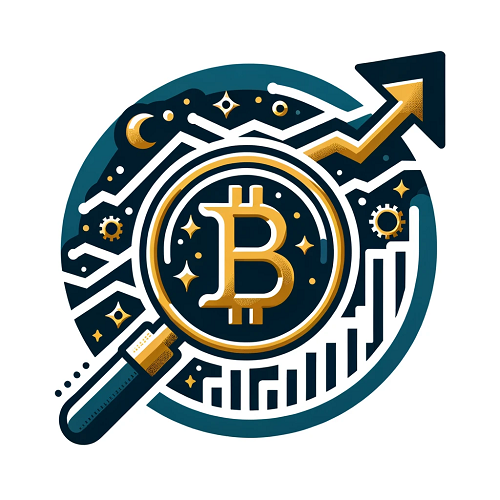

# **Prédiction Bitcoin**

### **Chargement et préparation des données**

In [ ]:
# Installer h5py pour pouvoir sauvegarder le modèle
!pip install h5py

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf


In [ ]:
# Récupération des données sur le Bitcoin
btc = yf.Ticker("BTC-USD")

# Récupération de l'historique des prix du Bitcoin sur un an, à intervalles quotidiens
btc_data = btc.history(period="1y", interval="1d")
print(btc_data.head())


                                   Open          High           Low  \
Date                                                                  
2024-10-16 00:00:00+00:00  67042.460938  68375.289062  66758.726562   
2024-10-17 00:00:00+00:00  67617.078125  67912.210938  66647.390625   
2024-10-18 00:00:00+00:00  67419.109375  68969.750000  67177.820312   
2024-10-19 00:00:00+00:00  68418.976562  68668.007812  68024.640625   
2024-10-20 00:00:00+00:00  68364.179688  69359.007812  68105.718750   

                                  Close       Volume  Dividends  Stock Splits  
Date                                                                           
2024-10-16 00:00:00+00:00  67612.718750  38195189534        0.0           0.0  
2024-10-17 00:00:00+00:00  67399.835938  32790898511        0.0           0.0  
2024-10-18 00:00:00+00:00  68418.789062  36857165014        0.0           0.0  
2024-10-19 00:00:00+00:00  68362.734375  14443497908        0.0           0.0  
2024-10-20 00:00:00+00

In [ ]:
# Affichage de la dimension des données
btc_data.shape

(366, 7)

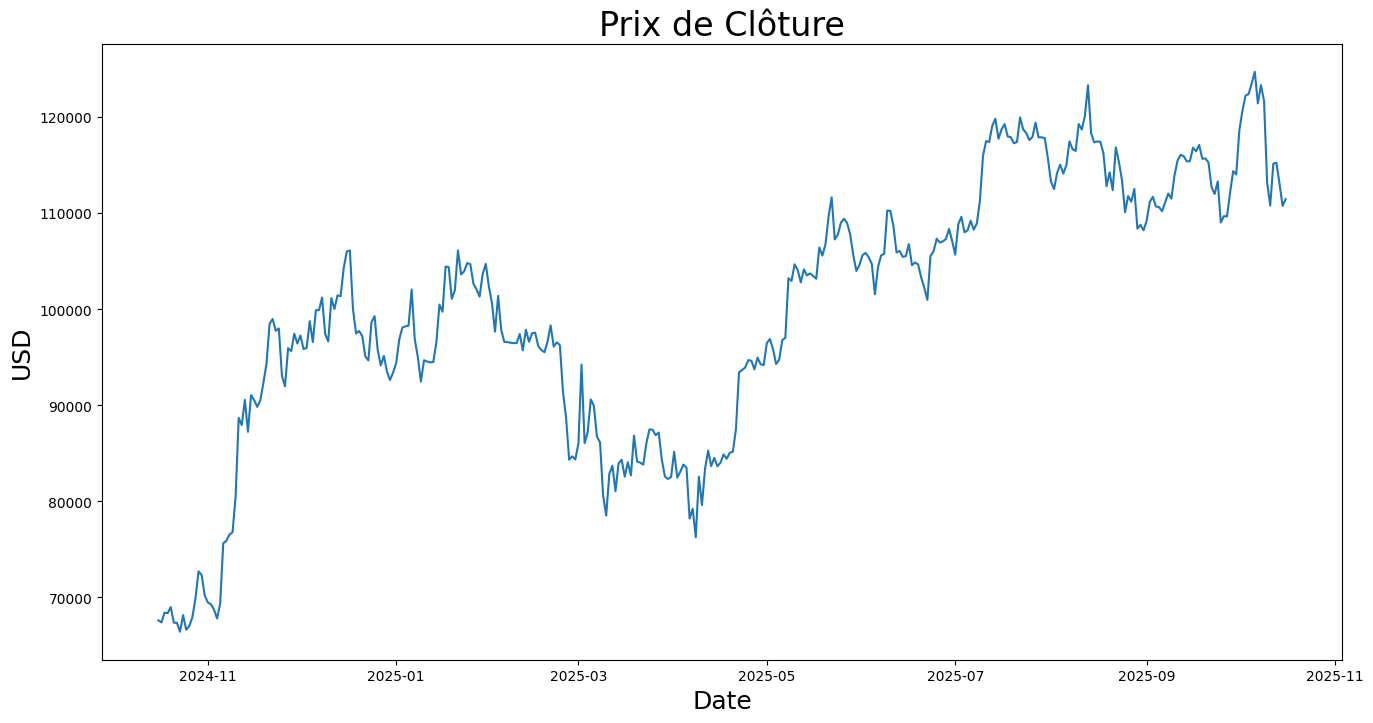

In [ ]:
# Tracé du prix de clôture
plt.figure(figsize=(16,8))
plt.title('Prix de Clôture', fontsize=24)
plt.plot(btc_data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

In [ ]:
# Création d'un nouveau DataFrame contenant uniquement le prix de clôture
data = btc_data.filter(['Close'])
# Conversion du DataFrame en tableau numpy
dataset = data.values
# Calcul du nombre de lignes à utiliser pour l'entraînement
# math.ceil arrondit au nombre supérieur
training_data_len = math.ceil(len(dataset) * .8) # On utilise 80% des données pour l'entraînement


In [ ]:
# Mise à l'échelle des données
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [ ]:
# Création du dataset d'entraînement
train_data = scaled_data[0:training_data_len, :]
# Division des données en ensembles X_train et y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])

  if i <= 60:
    print(X_train)
    print(y_train)
    print()


[array([0.02024205, 0.01659182, 0.03406348, 0.03310233, 0.04405852,
       0.0160434 , 0.01593288, 0.        , 0.02964419, 0.00360455,
       0.00998794, 0.02567032, 0.05959435, 0.1078234 , 0.10129132,
       0.06486575, 0.05230206, 0.0489894 , 0.03959034, 0.02365063,
       0.05019462, 0.15786745, 0.16242472, 0.17340917, 0.17741105,
       0.24077351, 0.38184432, 0.36905853, 0.41412602, 0.35696355,
       0.42238804, 0.41368557, 0.40146642, 0.41341403, 0.44429775,
       0.47851742, 0.54993735, 0.55838959, 0.53746408, 0.54151994,
       0.45730363, 0.4381512 , 0.50634715, 0.50103061, 0.53204989,
       0.51468941, 0.52893375, 0.50468004, 0.50702672, 0.55446073,
       0.51716737, 0.57421678, 0.57426179, 0.59676989, 0.53155598,
       0.51857099, 0.59568991, 0.57631363, 0.60059775, 0.59911818])]
[np.float64(0.6492846687402538)]



In [ ]:
len(X_train)  # Afficher la longueur de X_train


233

In [ ]:
# Conversion en tableau numpy
X_train, y_train = np.array(X_train), np.array(y_train)


In [ ]:
# Redimensionnement de X_train pour l'adapter au modèle LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [ ]:
# Création du dataset de test
test_data = scaled_data[training_data_len - 60:, :]


In [ ]:
# Création des ensembles X_test et y_test
X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])


In [ ]:
# Conversion en tableau numpy et redimensionnement de X_test
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



### **Construction du modèle_1 LSTM**

In [ ]:
# Construction et entraînement des modèles LSTM
tf.random.set_seed(42)

# Construction du modèle LSTM modèle_1
modele_1 = Sequential()
modele_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
modele_1.add(LSTM(50, return_sequences=False))
modele_1.add(Dense(25))
modele_1.add(Dense(1))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compilation du modèle_1
modele_1.compile(optimizer='adam', loss='mse')

### **Entraînement du modèle_1**

In [ ]:
# Entraînement du modèle_1
historique_1 = modele_1.fit(X_train, y_train, batch_size=1, epochs=50)

Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0288
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0072
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0062
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0055
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0050
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0046
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0042
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0037
Epoch 9/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0033
Epoch 10/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0028
Epoch 11/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0024
Epoch 12/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0022
Epoch 13/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.0021
Epoch 14/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0020
Epoch 15/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Prédictions du modèle_1
predictions_1 = modele_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


In [ ]:
# Calcul de l'erreur quadratique moyenne pour le modèle_1
rmse_1 = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse_1


np.float64(517.1805436643835)

In [ ]:
modele_1.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 13185806336.0000 


13220892672.0

Text(0.5, 0, 'époques')

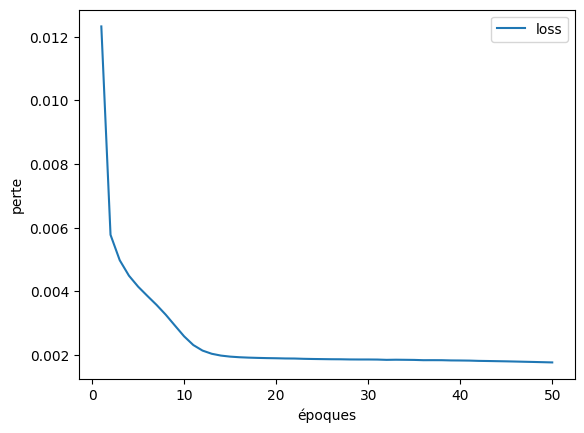

In [ ]:
# Tracé de l'historique d'entraînement pour le modèle_1
historiquePourGraphique = pd.DataFrame(historique_1.history)
historiquePourGraphique.index += 1
historiquePourGraphique.plot()
plt.ylabel("perte")
plt.xlabel("époques")


### **Construction et entraînement du modèle_2 LSTM**

In [ ]:
# Construction et entraînement du modèle LSTM modèle_2
modele_2 = Sequential()
modele_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
modele_2.add(LSTM(50, return_sequences=False))
modele_2.add(Dense(25))
modele_2.add(Dense(1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compilation et entraînement du modèle_2
modele_2.compile(optimizer='Adam', loss='mse')
historique_2 = modele_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0193
Epoch 2/6
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0071
Epoch 3/6
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0060
Epoch 4/6
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0054
Epoch 5/6
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0049
Epoch 6/6
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0044


In [ ]:
# Prédictions du modèle_2
predictions_2 = modele_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


In [ ]:
# Calcul de l'erreur quadratique moyenne pour le modèle_2
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_2

np.float64(5073.047303082192)

### **Évaluation et visualisation des performances des modèles**

/tmp/ipython-input-3267067158.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valide_1['Prédictions'] = predictions_1
/tmp/ipython-input-3267067158.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valide_2['Prédictions'] = predictions_2


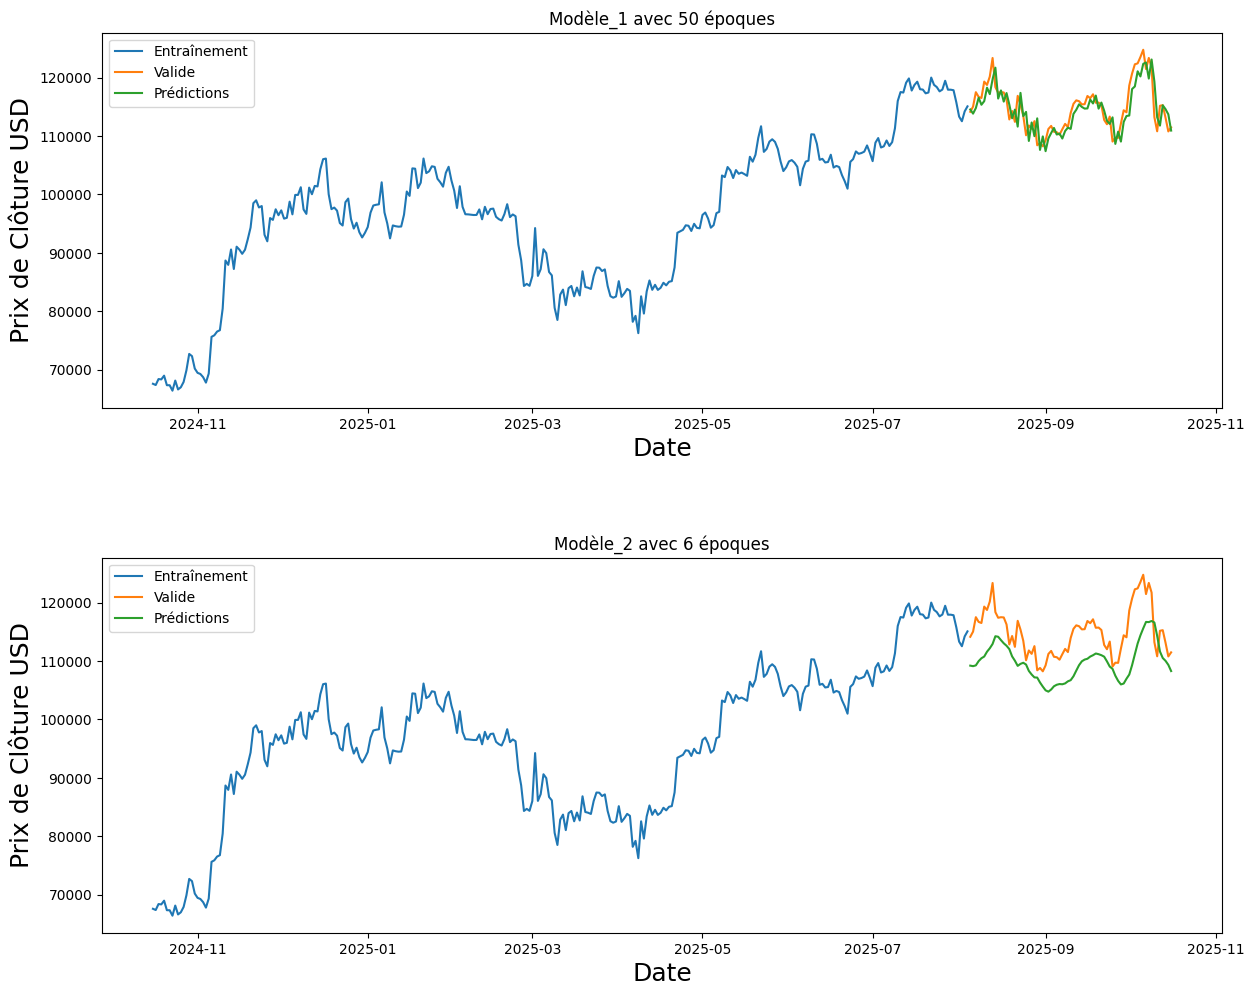

In [ ]:
# Tracé des prédictions des deux modèles
# Préparation des données pour le tracé
train = data[:training_data_len]

# Données pour le modèle_1
valide_1 = data[training_data_len:]
valide_1['Prédictions'] = predictions_1

# Données pour le modèle_2
valide_2 = data[training_data_len:]
valide_2['Prédictions'] = predictions_2

# Visualisation des données
# Modèle_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Modèle_1 avec 50 époques')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de Clôture USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valide_1[['Close', 'Prédictions']])
plt.legend(['Entraînement', 'Valide', 'Prédictions'], loc='upper left')

# Modèle_2
plt.subplot(2, 1, 2)
plt.title('Modèle_2 avec 6 époques')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de Clôture USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valide_2[['Close', 'Prédictions']])
plt.legend(['Entraînement', 'Valide', 'Prédictions'], loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
# Obtention des valeurs de prix de clôture des 60 derniers jours et conversion du DataFrame en tableau
derniers_60_jours = data[-60:].values
# Mise à l'échelle des données pour qu'elles soient comprises entre 0 et 1
derniers_60_jours_mise_a_l_echelle = scaler.fit_transform(derniers_60_jours)
# Création d'une liste vide
nouveau_X_test = []
# Ajout des 60 derniers jours
nouveau_X_test.append(derniers_60_jours_mise_a_l_echelle)
# Conversion de l'ensemble de données X_test en tableau numpy
nouveau_X_test = np.array(nouveau_X_test)
# Redimensionnement des données
nouveau_X_test = np.reshape(nouveau_X_test, (nouveau_X_test.shape[0], nouveau_X_test.shape[1], 1))
# Obtention du prix prédit mis à l'échelle
pred_prix = modele_1.predict(nouveau_X_test)
# Annulation de la mise à l'échelle
pred_prix = scaler.inverse_transform(pred_prix)
print(pred_prix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[112719.73]]


In [ ]:
# Répétition des étapes pour obtenir les valeurs de prix de clôture des 60 derniers jours pour le modèle 2
derniers_60_jours = data[-60:].values
derniers_60_jours_mise_a_l_echelle = scaler.fit_transform(derniers_60_jours)
nouveau_X_test = []
nouveau_X_test.append(derniers_60_jours_mise_a_l_echelle)
nouveau_X_test = np.array(nouveau_X_test)
nouveau_X_test = np.reshape(nouveau_X_test, (nouveau_X_test.shape[0], nouveau_X_test.shape[1], 1))
pred_prix = modele_2.predict(nouveau_X_test)
pred_prix = scaler.inverse_transform(pred_prix)
print(pred_prix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[112618.07]]


In [ ]:
modele_1.save('modele_1_lstm_bitcoin.h5')  # Sauvegarder le modèle_1


In [ ]:
modele_2.save('modele_2_lstm_bitcoin.h5')  # Sauvegarder le modèle_2

# **Prédiction Etherum**

### **Chargement et préparation des données**

In [ ]:
# Récupération des données sur l'Etherum
eth = yf.Ticker("ETH-USD")

# Récupération de l'historique des prix de l'Etherum sur un an, à intervalles quotidiens
eth_data = eth.history(period="1y", interval="1d")
print(eth_data.head())

                                  Open         High          Low        Close  \
Date                                                                            
2023-03-25 00:00:00+00:00  1751.469482  1762.674561  1716.651978  1743.764771   
2023-03-26 00:00:00+00:00  1743.842163  1797.880249  1741.182861  1775.676758   
2023-03-27 00:00:00+00:00  1775.481323  1781.379272  1690.516602  1715.460815   
2023-03-28 00:00:00+00:00  1715.327393  1791.110962  1702.564697  1772.785645   
2023-03-29 00:00:00+00:00  1772.899902  1825.600952  1772.899902  1793.001831   

                               Volume  Dividends  Stock Splits  
Date                                                            
2023-03-25 00:00:00+00:00  6614309912        0.0           0.0  
2023-03-26 00:00:00+00:00  6990313307        0.0           0.0  
2023-03-27 00:00:00+00:00  8585750760        0.0           0.0  
2023-03-28 00:00:00+00:00  8346890042        0.0           0.0  
2023-03-29 00:00:00+00:00  9136176952     

In [ ]:
# Affichage de la dimension des données
eth_data.shape

(367, 7)

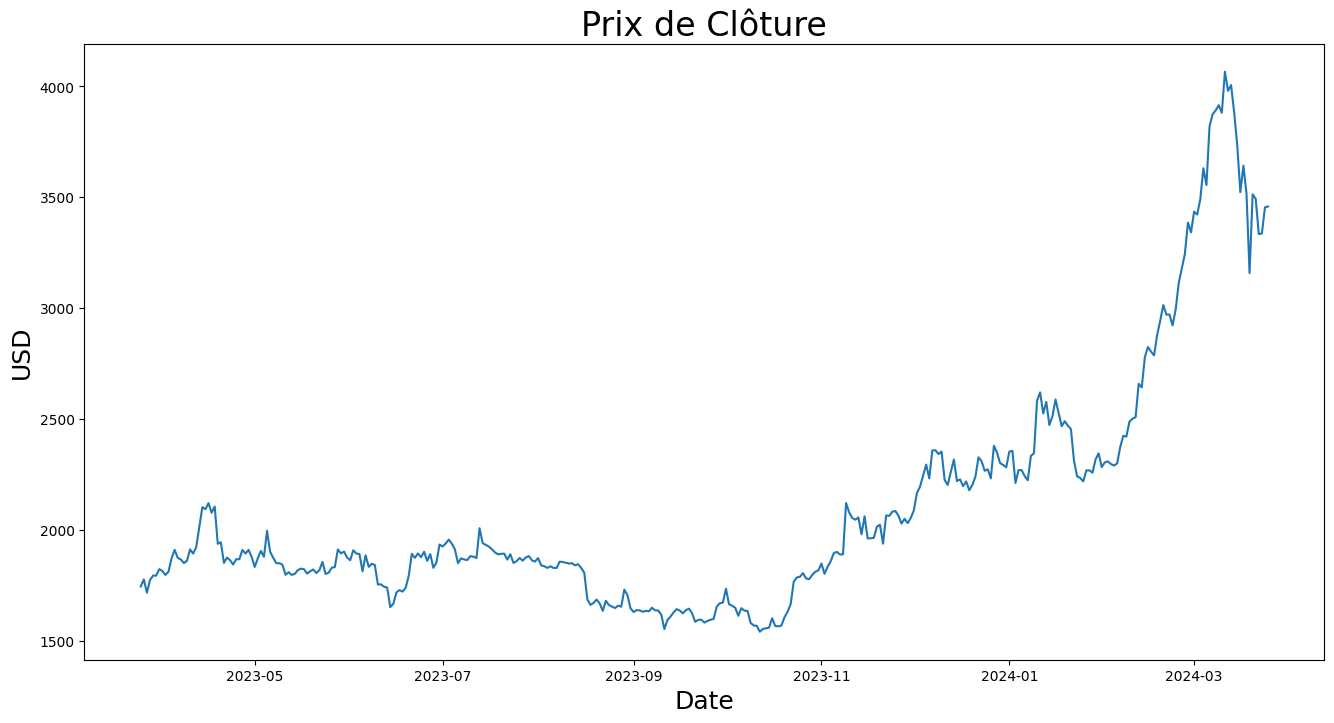

In [ ]:
# Tracé du prix de clôture
plt.figure(figsize=(16,8))
plt.title('Prix de Clôture', fontsize=24)
plt.plot(eth_data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

In [ ]:
# Création d'un nouveau DataFrame contenant uniquement le prix de clôture
data = eth_data.filter(['Close'])
# Conversion du DataFrame en tableau numpy
dataset = data.values
# Calcul du nombre de lignes à utiliser pour l'entraînement
# math.ceil arrondit au nombre supérieur
training_data_len = math.ceil(len(dataset) * .8) # On utilise 80% des données pour l'entraînement

In [ ]:
# Mise à l'échelle des données
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
# Création du dataset d'entraînement
train_data = scaled_data[0:training_data_len, :]
# Division des données en ensembles X_train et y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])

  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.08079377, 0.09342302, 0.06959242, 0.09227885, 0.10027946,
       0.10017472, 0.11176429, 0.10853436, 0.10135048, 0.10712411,
       0.13114945, 0.14623113, 0.13190829, 0.12902464, 0.12263802,
       0.12655187, 0.14705964, 0.13953329, 0.15080924, 0.18719966,
       0.22242196, 0.21879343, 0.22969207, 0.21237279, 0.22357038,
       0.15703098, 0.15968023, 0.12283657, 0.13242516, 0.12761019,
       0.11997036, 0.12946692, 0.12939194, 0.14610146, 0.13966117,
       0.14615316, 0.13349198, 0.1156952 , 0.13106403, 0.14446522,
       0.13380058, 0.18024482, 0.14271201, 0.13196916, 0.12245777,
       0.12228381, 0.11982949, 0.10166015, 0.10622284, 0.10151145,
       0.10324726, 0.10999442, 0.11259512, 0.11169999, 0.10373306,
       0.10803131, 0.11115323, 0.1048423 , 0.10998843, 0.12457026])]
[0.10308856413340539]



In [ ]:
len(X_train)  # Afficher la longueur de X_train

234

In [ ]:
# Conversion en tableau numpy
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Redimensionnement de X_train pour l'adapter au modèle LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Création du dataset de test
test_data = scaled_data[training_data_len - 60:, :]

In [ ]:
# Création des ensembles X_test et y_test
X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])

In [ ]:
# Conversion en tableau numpy et redimensionnement de X_test
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


### **Construction du modèle_1 LSTM**

In [ ]:
# Construction et entraînement des modèles LSTM
tf.random.set_seed(42)

# Construction du modèle LSTM modèle_1
modele_1 = Sequential()
modele_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
modele_1.add(LSTM(50, return_sequences=False))
modele_1.add(Dense(25))
modele_1.add(Dense(1))


In [ ]:
# Compilation du modèle_1
modele_1.compile(optimizer='adam', loss='mse')

### **Entraînement du modèle_1**

In [ ]:
# Entraînement du modèle_1
historique_1 = modele_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
234/234 [==============================] - 11s 34ms/step - loss: 0.0023
Epoch 2/10
234/234 [==============================] - 7s 31ms/step - loss: 0.0013
Epoch 3/10
234/234 [==============================] - 8s 35ms/step - loss: 0.0011
Epoch 4/10
234/234 [==============================] - 8s 33ms/step - loss: 8.1094e-04
Epoch 5/10
234/234 [==============================] - 7s 32ms/step - loss: 7.5278e-04
Epoch 6/10
234/234 [==============================] - 8s 34ms/step - loss: 7.2673e-04
Epoch 7/10
234/234 [==============================] - 7s 30ms/step - loss: 6.9080e-04
Epoch 8/10
234/234 [==============================] - 8s 34ms/step - loss: 6.8747e-04
Epoch 9/10
234/234 [==============================] - 8s 34ms/step - loss: 7.4944e-04
Epoch 10/10
234/234 [==============================] - 7s 31ms/step - loss: 5.2732e-04


In [ ]:
# Prédictions du modèle_1
predictions_1 = modele_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)

3/3 [==============================] - 1s 16ms/step


In [ ]:
# Calcul de l'erreur quadratique moyenne pour le modèle_1
rmse_1 = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse_1

161.3168376765839

In [ ]:
modele_1.evaluate(X_test, y_test)

3/3 [==============================] - 1s 16ms/step - loss: 9079798.0000


9079798.0

Text(0.5, 0, 'époques')

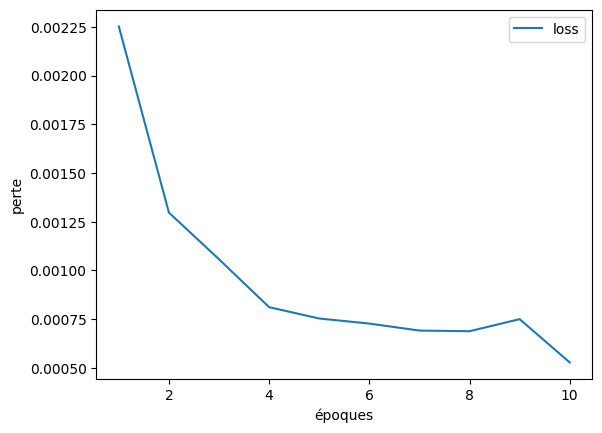

In [ ]:
# Tracé de l'historique d'entraînement pour le modèle_1
historiquePourGraphique = pd.DataFrame(historique_1.history)
historiquePourGraphique.index += 1
historiquePourGraphique.plot()
plt.ylabel("perte")
plt.xlabel("époques")

### **Construction et entraînement du modèle_2 LSTM**

In [ ]:
# Construction et entraînement du modèle LSTM modèle_2
modele_2 = Sequential()
modele_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
modele_2.add(LSTM(50, return_sequences=False))
modele_2.add(Dense(25))
modele_2.add(Dense(1))

In [ ]:
#Compilation et entraînement du modèle_2
modele_2.compile(optimizer='Adam', loss='mse')
historique_2 = modele_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
234/234 [==============================] - 11s 34ms/step - loss: 0.0018
Epoch 2/6
234/234 [==============================] - 8s 35ms/step - loss: 0.0012
Epoch 3/6
234/234 [==============================] - 7s 31ms/step - loss: 9.8776e-04
Epoch 4/6
234/234 [==============================] - 8s 34ms/step - loss: 7.7041e-04
Epoch 5/6
234/234 [==============================] - 8s 33ms/step - loss: 7.1043e-04
Epoch 6/6
234/234 [==============================] - 7s 32ms/step - loss: 6.8616e-04


In [ ]:
# Prédictions du modèle_2
predictions_2 = modele_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)

3/3 [==============================] - 1s 16ms/step


In [ ]:
# Calcul de l'erreur quadratique moyenne pour le modèle_2
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_2

64.3524387307363

### **Évaluation et visualisation des performances des modèles**

<ipython-input-55-606085dfef4b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valide_1['Prédictions'] = predictions_1
<ipython-input-55-606085dfef4b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valide_2['Prédictions'] = predictions_2


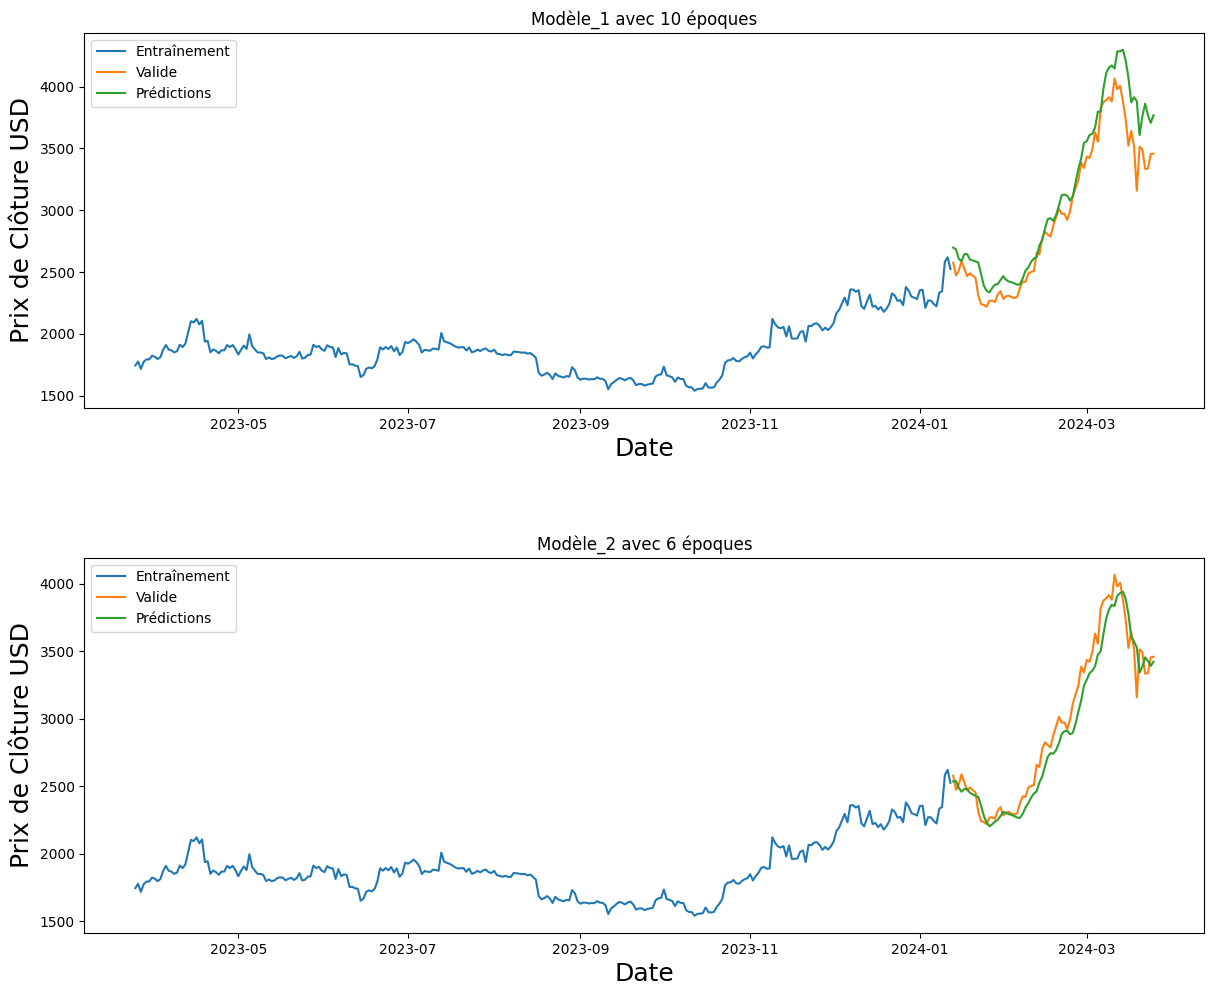

In [ ]:
# Tracé des prédictions des deux modèles
# Préparation des données pour le tracé
train = data[:training_data_len]

# Données pour le modèle_1
valide_1 = data[training_data_len:]
valide_1['Prédictions'] = predictions_1

# Données pour le modèle_2
valide_2 = data[training_data_len:]
valide_2['Prédictions'] = predictions_2

# Visualisation des données
# Modèle_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Modèle_1 avec 10 époques')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de Clôture USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valide_1[['Close', 'Prédictions']])
plt.legend(['Entraînement', 'Valide', 'Prédictions'], loc='upper left')

# Modèle_2
plt.subplot(2, 1, 2)
plt.title('Modèle_2 avec 6 époques')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de Clôture USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valide_2[['Close', 'Prédictions']])
plt.legend(['Entraînement', 'Valide', 'Prédictions'], loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
# Obtention des valeurs de prix de clôture des 60 derniers jours et conversion du DataFrame en tableau
derniers_60_jours = data[-60:].values
# Mise à l'échelle des données pour qu'elles soient comprises entre 0 et 1
derniers_60_jours_mise_a_l_echelle = scaler.fit_transform(derniers_60_jours)
# Création d'une liste vide
nouveau_X_test = []
# Ajout des 60 derniers jours
nouveau_X_test.append(derniers_60_jours_mise_a_l_echelle)
# Conversion de l'ensemble de données X_test en tableau numpy
nouveau_X_test = np.array(nouveau_X_test)
# Redimensionnement des données
nouveau_X_test = np.reshape(nouveau_X_test, (nouveau_X_test.shape[0], nouveau_X_test.shape[1], 1))
# Obtention du prix prédit mis à l'échelle
pred_prix = modele_1.predict(nouveau_X_test)
# Annulation de la mise à l'échelle
pred_prix = scaler.inverse_transform(pred_prix)
print(pred_prix)

1/1 [==============================] - 0s 33ms/step
[[3685.1416]]


In [ ]:
# Répétition des étapes pour obtenir les valeurs de prix de clôture des 60 derniers jours pour le modèle 2
derniers_60_jours = data[-60:].values
derniers_60_jours_mise_a_l_echelle = scaler.fit_transform(derniers_60_jours)
nouveau_X_test = []
nouveau_X_test.append(derniers_60_jours_mise_a_l_echelle)
nouveau_X_test = np.array(nouveau_X_test)
nouveau_X_test = np.reshape(nouveau_X_test, (nouveau_X_test.shape[0], nouveau_X_test.shape[1], 1))
pred_prix = modele_2.predict(nouveau_X_test)
pred_prix = scaler.inverse_transform(pred_prix)
print(pred_prix)

1/1 [==============================] - 0s 26ms/step
[[3453.2148]]


In [ ]:
modele_1.save('modele_1_lstm_etherum.h5')  # Sauvegarder le modèle_1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
modele_2.save('modele_2_lstm_etherum.h5')  # Sauvegarder le modèle_2